In [18]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader

import torchvision.datasets as datasets

import torchvision.transforms as transforms

from tqdm.notebook import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt

In [4]:
dataset_root = "dataset"
epochs = 5
learning_rate = 1e-4
batch_size = 64

In [6]:
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.1307],[0.308])])

In [23]:
train = datasets.MNIST(dataset_root, train=True, download=True, transform=transform)
test = datasets.MNIST(dataset_root, train=True, download=True, transform=transform)

train_split = 0.9
train_nos = int(len(train) * train_split)
valid_nos = int(len(train) - train_nos)

train, valid = torch.utils.data.random_split(train, [train_nos, valid_nos], 
                                             generator=torch.Generator().manual_seed(42))

print(len(train),len(valid), len(test))

54000 6000 60000


In [24]:
train_loader = dataloader.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = dataloader.DataLoader(valid, batch_size=batch_size)
test_loader = dataloader.DataLoader(test, batch_size=batch_size)

In [27]:
class LeNet(nn.Module):
    def __init__(self, input_channels):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.linear1 = nn.Linear(16*5*5, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)

    def forward(self, x):
        out1 = self.maxpool(F.relu(self.conv1(x)))
        out2 = self.maxpool(F.relu(self.conv2(out1)))
        out2 = out2.view(out2.shape[0], -1)
        out3 = F.relu(self.linear1(out2))
        out4 = F.relu(self.linear2(out3))
        out5 = self.linear3(out4)
        return out5

In [44]:
dataiter = iter(test_loader)
test_images, test_label = dataiter.__next__()
model = LeNet(input_channels=test_images.shape[1]).to(device)
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)


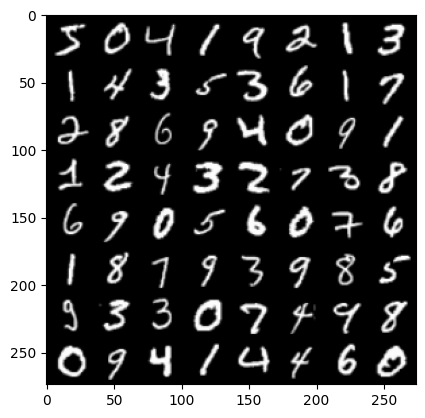

In [45]:
plt.Figure(figsize=(20, 10))
out = torchvision.utils.make_grid(test_images,8,normalize=True)
plt.imshow(out.numpy().transpose(1,2,0))

In [46]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [47]:
def train_epoch(model, loss_function, optimizer, device, loader, loss_logger):
    for (x, y) in tqdm(loader, desc = "Training Epochs", leave=False):
        y_train_hat = model(x.to(device))
        loss = loss_function(y_train_hat, y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_logger.append(loss.item())
    return model, optimizer, loss_logger

In [48]:
def evaluate(model, device, loader):
    eval_accuracy = 0
    model.eval()
    with torch.no_grad():
        for (x,y) in tqdm(loader, desc="Evaluation epoch", leave=False):
            y_test_hat = model(x.to(device))
            eval_accuracy += (y_test_hat.argmax(1) ==  y.to(device)).sum().item()
    return eval_accuracy / len(loader.dataset)

In [49]:
train_loss_logger = []
train_acc_logger = []
valid_acc_logger = []

In [50]:
for epoch in trange(epochs, desc="Outer epochs", leave=False):
    model, optimizer, train_loss_logger = train_epoch(model = model,
                                                      loss_function=loss_function,
                                                      optimizer=optimizer,
                                                      device=device,
                                                      loader=train_loader,
                                                      loss_logger=train_loss_logger)
    train_acc_logger.append(evaluate(model=model, device=device, loader=train_loader))
    valid_acc_logger.append(evaluate(model=model, device=device, loader=valid_loader))

Outer epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation epoch:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation epoch:   0%|          | 0/94 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation epoch:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation epoch:   0%|          | 0/94 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation epoch:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation epoch:   0%|          | 0/94 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation epoch:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation epoch:   0%|          | 0/94 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation epoch:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation epoch:   0%|          | 0/94 [00:00<?, ?it/s]

Text(0.5, 1.0, 'LeNet Training Loss')

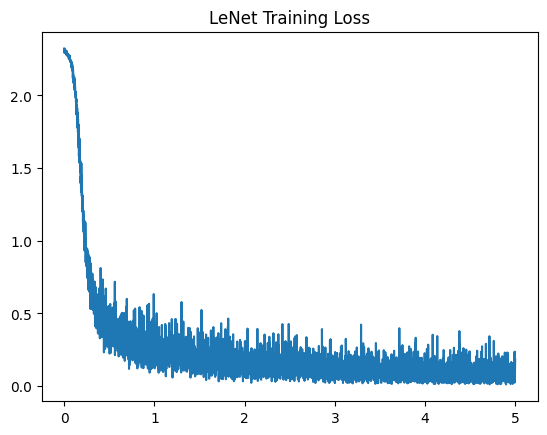

In [51]:
plt.Figure(figsize=(10,10))
train_x = np.linspace(0, epochs, len(train_loss_logger))
plt.plot(train_x, train_loss_logger)
plt.title("LeNet Training Loss")

/tmp/ipykernel_6811/2727597819.py:7: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend("Training Accuracy", "Validation Accuracy")


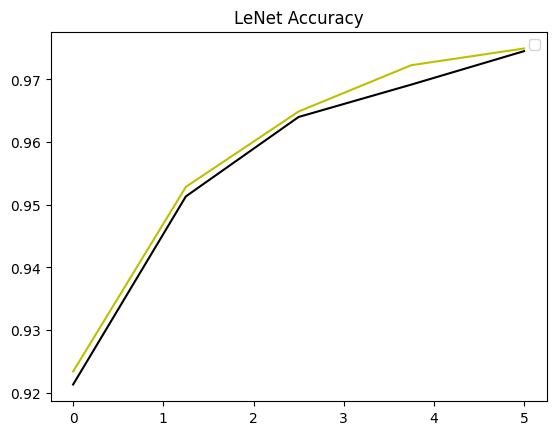

In [52]:
plt.Figure(figsize=(10,10))
train_x = np.linspace(0, epochs, len(train_acc_logger))
plt.plot(train_x, train_acc_logger, c='y')
valid_x = np.linspace(0, epochs, len(valid_acc_logger))
plt.plot(valid_x, valid_acc_logger, c='k')
plt.title("LeNet Accuracy")
plt.legend("Training Accuracy", "Validation Accuracy")

In [53]:
test_accuracy = evaluate(model=model, device=device, loader=test_loader)
print(f"Test Accuracy : {test_accuracy * 100}")

Evaluation epoch:   0%|          | 0/938 [00:00<?, ?it/s]

Test Accuracy : 97.48833333333333


Predicted Values 
 list[array([5, 0, 4, 1, 9, 2, 1, 3])]
True Values 
 [5 0 4 1 9 2 1 3]


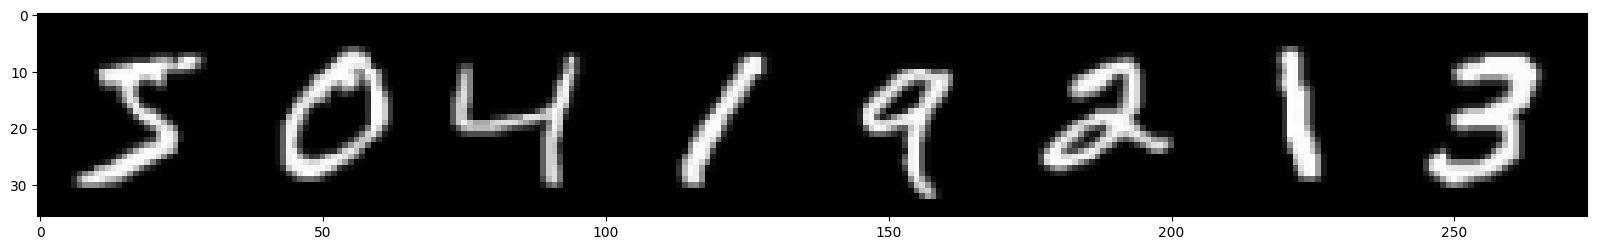

In [54]:
with torch.no_grad():
    y_test_hat = model(test_images[:8].to(device))
    pred = y_test_hat.argmax(-1)

plt.figure(figsize=(20,10))
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True)
plt.imshow(out.numpy().transpose(1,2,0))

print("Predicted Values \n", list[pred.cpu().numpy()])
print("True Values \n", test_label[:8].numpy())

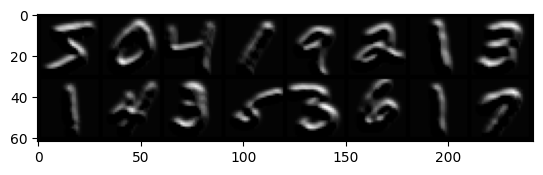

In [61]:
with torch.no_grad():
    model_out = F.relu(model.conv1(test_images.to(device)))

plt.Figure(figsize=(20,10))
out = torchvision.utils.make_grid(model_out[:16,5].unsqueeze(1).detach().cpu(), 8, normalize=True)
plt.imshow(out.numpy().transpose((1,2,0)))

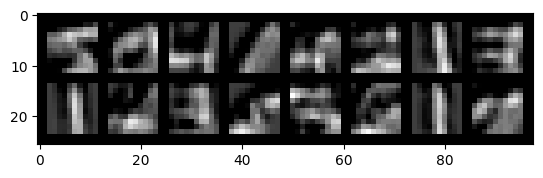

In [72]:
with torch.no_grad():
    model_out2 =  F.relu(model.conv2(model.maxpool(F.relu(model.conv1(test_images.to(device))))))

plt.Figure(figsize=(20,10))
out = torchvision.utils.make_grid(model_out2[:16,15].unsqueeze(1).detach().cpu(), 8, normalize=True)
plt.imshow(out.numpy().transpose((1,2,0)))